In [0]:
!wget https://www.machinehack.com/wp-content/uploads/2020/05/Glass_Quality_Participants_Data.zip

--2020-05-24 18:29:05--  https://www.machinehack.com/wp-content/uploads/2020/05/Glass_Quality_Participants_Data.zip
Resolving www.machinehack.com (www.machinehack.com)... 107.180.71.20
Connecting to www.machinehack.com (www.machinehack.com)|107.180.71.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76971 (75K) [application/zip]
Saving to: ‘Glass_Quality_Participants_Data.zip’

Glass_Quality_Parti 100%[===================>]  75.17K   328KB/s    in 0.2s    

2020-05-24 18:29:05 (328 KB/s) - ‘Glass_Quality_Participants_Data.zip’ saved [76971/76971]



In [0]:
!unzip Glass_Quality_Participants_Data.zip

Archive:  Glass_Quality_Participants_Data.zip
   creating: Glass_Quality_Participants_Data/
  inflating: Glass_Quality_Participants_Data/Test.csv  
  inflating: __MACOSX/Glass_Quality_Participants_Data/._Test.csv  
  inflating: Glass_Quality_Participants_Data/Sample_Submission.xlsx  
  inflating: __MACOSX/Glass_Quality_Participants_Data/._Sample_Submission.xlsx  
  inflating: Glass_Quality_Participants_Data/Train.csv  
  inflating: __MACOSX/Glass_Quality_Participants_Data/._Train.csv  


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
train = pd.read_csv('Glass_Quality_Participants_Data/Train.csv')
test = pd.read_csv('Glass_Quality_Participants_Data/Test.csv')
sub = pd.read_excel('Glass_Quality_Participants_Data/Sample_Submission.xlsx')

In [97]:
train.head(5)

,grade_A_Component_1,grade_A_Component_2,max_luminosity,thickness,xmin,xmax,ymin,ymax,pixel_area,log_area,x_component_1,x_component_2,x_component_3,x_component_4,x_component_5,class
0,0,1,150,36,144,172,947225,947332,439,439.099273,0,0,1,0,0,1
1,1,0,134,55,1144,1152,2379058,2379624,329,329.205616,1,0,0,0,0,1
2,1,0,135,65,950,974,1038442,1036754,300,300.120598,0,0,0,0,0,2
3,0,1,123,35,41,220,1705580,1705604,6803,6803.778622,0,0,1,0,0,1
4,1,0,138,69,462,466,1088124,1086579,251,251.401943,0,0,0,0,0,2


In [98]:
test.head(5)

,grade_A_Component_1,grade_A_Component_2,max_luminosity,thickness,xmin,xmax,ymin,ymax,pixel_area,log_area,x_component_1,x_component_2,x_component_3,x_component_4,x_component_5
0,1,0,123,65,33,54,1646439,1646893,632,632.391749,0,1,0,0,0
1,0,1,158,99,125,132,189874,189529,421,421.928609,0,0,0,0,0
2,0,1,120,35,64,75,12986873,12986862,272,272.212214,1,0,0,0,0
3,0,1,130,39,57,177,309634,310824,3312,3312.310581,0,0,1,0,0
4,1,0,142,75,23,79,5368307,5367467,862,862.499179,0,0,0,0,0


In [99]:
train.isnull().sum(),test.isnull().sum(),train.shape,test.shape

(grade_A_Component_1    0
 grade_A_Component_2    0
 max_luminosity         0
 thickness              0
 xmin                   0
 xmax                   0
 ymin                   0
 ymax                   0
 pixel_area             0
 log_area               0
 x_component_1          0
 x_component_2          0
 x_component_3          0
 x_component_4          0
 x_component_5          0
 class                  0
 dtype: int64, grade_A_Component_1    0
 grade_A_Component_2    0
 max_luminosity         0
 thickness              0
 xmin                   0
 xmax                   0
 ymin                   0
 ymax                   0
 pixel_area             0
 log_area               0
 x_component_1          0
 x_component_2          0
 x_component_3          0
 x_component_4          0
 x_component_5          0
 dtype: int64, (1358, 16), (583, 15))

In [0]:
train['class']=train['class']-1

In [0]:
train_df=train
test_df=test

In [0]:
X = train_df.drop(labels=['class'], axis=1)
y = train_df['class'].values

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [104]:
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((1018, 15), (1018,), (340, 15), (340,))

In [0]:
from sklearn.metrics import log_loss

In [110]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_cv, label=y_cv)

param = {'objective': 'multiclass',
         'num_class': 2,
         'boosting': 'gbdt',  
         'metric': 'multi_logloss',
         'learning_rate': 0.01, 
         'num_iterations': 1000,
         'num_leaves': 100,
         'max_depth': -1,
         'min_data_in_leaf': 15,
         'bagging_fraction':0.9,
         'bagging_freq': 1,
         'feature_fraction': 0.7,
         'lambda_l2': 0.8,
         'min_data_per_group': 75,
         'max_bin': 255,
         'is_unbalance':False
         }

clf = lgb.train(params=param, 
                early_stopping_rounds=200,
                verbose_eval=100,
                train_set=train_data,
                valid_sets=[test_data])

y_pred = clf.predict(X_cv)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.432508
[200]	valid_0's multi_logloss: 0.353201
[300]	valid_0's multi_logloss: 0.324383
[400]	valid_0's multi_logloss: 0.313522
[500]	valid_0's multi_logloss: 0.313319
[600]	valid_0's multi_logloss: 0.317623
Early stopping, best iteration is:
[449]	valid_0's multi_logloss: 0.312293


In [111]:
log_loss(y_cv, y_pred)

0.312293259131336

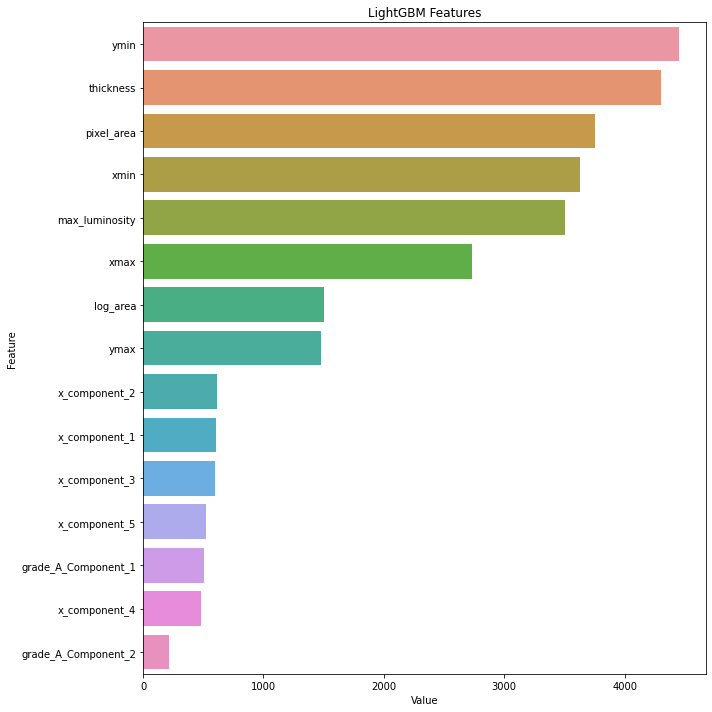

In [112]:
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(), X.columns), reverse=True)[:], columns=['Value','Feature'])
plt.figure(figsize=(10,10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [0]:
#feature_imp.loc[feature_imp.Value >= 0].sort_values(by=['Value'], ascending = False)

In [0]:
Xtest = test_df

In [123]:

from sklearn.model_selection import KFold, StratifiedKFold

errlgb = []
y_pred_totlgb = []

fold = StratifiedKFold(n_splits=30, shuffle=False, random_state=123456789)

for train_index, test_index in fold.split(X, y):
    
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)
    param = {'objective': 'multiclass',
         'num_class': 2,
         'boosting': 'gbdt',  
         'metric': 'multi_logloss',
         'learning_rate': 0.01, 
         'num_iterations': 2000,
         'num_leaves': 100,
         'max_depth': -1,
         'min_data_in_leaf': 15,
         'bagging_fraction':0.9,
         'bagging_freq': 1,
         'feature_fraction': 0.7,
         'lambda_l2': 0.8,
         'min_data_per_group': 75,
         'max_bin': 255,
         'is_unbalance':False
         }
    clf = lgb.train(params=param,
                     early_stopping_rounds=200,
                     verbose_eval=100,
                     train_set=train_data,
                     valid_sets=[test_data])

    y_pred = clf.predict(X_test)
    print("Log Loss: ", (log_loss(y_test, y_pred)))
    
    errlgb.append(log_loss(y_test, y_pred))
    p = clf.predict(Xtest)
    y_pred_totlgb.append(p)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.425837
[200]	valid_0's multi_logloss: 0.340404
[300]	valid_0's multi_logloss: 0.306499
[400]	valid_0's multi_logloss: 0.287578
[500]	valid_0's multi_logloss: 0.275924
[600]	valid_0's multi_logloss: 0.273279
[700]	valid_0's multi_logloss: 0.27503
[800]	valid_0's multi_logloss: 0.276989
Early stopping, best iteration is:
[634]	valid_0's multi_logloss: 0.271518
Log Loss:  0.2715181010225037
Training until validation scores don't improve for 200 rounds.


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's multi_logloss: 0.422116
[200]	valid_0's multi_logloss: 0.329144
[300]	valid_0's multi_logloss: 0.289395
[400]	valid_0's multi_logloss: 0.278753
[500]	valid_0's multi_logloss: 0.26864
[600]	valid_0's multi_logloss: 0.263382
[700]	valid_0's multi_logloss: 0.263449
[800]	valid_0's multi_logloss: 0.264563
Early stopping, best iteration is:
[642]	valid_0's multi_logloss: 0.261574
Log Loss:  0.2615738836132851
Training until validation scores don't improve for 200 rounds.


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's multi_logloss: 0.360413
[200]	valid_0's multi_logloss: 0.245576
[300]	valid_0's multi_logloss: 0.19711
[400]	valid_0's multi_logloss: 0.169732
[500]	valid_0's multi_logloss: 0.154038
[600]	valid_0's multi_logloss: 0.142899
[700]	valid_0's multi_logloss: 0.136148
[800]	valid_0's multi_logloss: 0.13285
[900]	valid_0's multi_logloss: 0.130497
[1000]	valid_0's multi_logloss: 0.12938
[1100]	valid_0's multi_logloss: 0.127305
[1200]	valid_0's multi_logloss: 0.124561
[1300]	valid_0's multi_logloss: 0.12232
[1400]	valid_0's multi_logloss: 0.119573
[1500]	valid_0's multi_logloss: 0.119227
[1600]	valid_0's multi_logloss: 0.119096
[1700]	valid_0's multi_logloss: 0.118385
[1800]	valid_0's multi_logloss: 0.118809
[1900]	valid_0's multi_logloss: 0.118893
Early stopping, best iteration is:
[1709]	valid_0's multi_logloss: 0.118281
Log Loss:  0.11828141174776363


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.444501
[200]	valid_0's multi_logloss: 0.398004
[300]	valid_0's multi_logloss: 0.394782
[400]	valid_0's multi_logloss: 0.405886
Early stopping, best iteration is:
[261]	valid_0's multi_logloss: 0.39318
Log Loss:  0.39317982956651265
Training until validation scores don't improve for 200 rounds.


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's multi_logloss: 0.439397
[200]	valid_0's multi_logloss: 0.376622
[300]	valid_0's multi_logloss: 0.358664
[400]	valid_0's multi_logloss: 0.358003
[500]	valid_0's multi_logloss: 0.357365
[600]	valid_0's multi_logloss: 0.368191
Early stopping, best iteration is:
[447]	valid_0's multi_logloss: 0.355555
Log Loss:  0.3555545542599252
Training until validation scores don't improve for 200 rounds.


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's multi_logloss: 0.412049
[200]	valid_0's multi_logloss: 0.329638
[300]	valid_0's multi_logloss: 0.288634
[400]	valid_0's multi_logloss: 0.268352
[500]	valid_0's multi_logloss: 0.256901
[600]	valid_0's multi_logloss: 0.247947
[700]	valid_0's multi_logloss: 0.240632
[800]	valid_0's multi_logloss: 0.23689
[900]	valid_0's multi_logloss: 0.231473
[1000]	valid_0's multi_logloss: 0.23038
[1100]	valid_0's multi_logloss: 0.229219
[1200]	valid_0's multi_logloss: 0.228161
[1300]	valid_0's multi_logloss: 0.227439
[1400]	valid_0's multi_logloss: 0.227712
[1500]	valid_0's multi_logloss: 0.229026
Early stopping, best iteration is:
[1320]	valid_0's multi_logloss: 0.226692
Log Loss:  0.2266917925472515
Training until validation scores don't improve for 200 rounds.


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's multi_logloss: 0.401316
[200]	valid_0's multi_logloss: 0.314788
[300]	valid_0's multi_logloss: 0.280284
[400]	valid_0's multi_logloss: 0.268504
[500]	valid_0's multi_logloss: 0.267488
[600]	valid_0's multi_logloss: 0.271504
Early stopping, best iteration is:
[459]	valid_0's multi_logloss: 0.266011
Log Loss:  0.2660111492321064
Training until validation scores don't improve for 200 rounds.


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's multi_logloss: 0.460629
[200]	valid_0's multi_logloss: 0.380705
[300]	valid_0's multi_logloss: 0.351481
[400]	valid_0's multi_logloss: 0.337418
[500]	valid_0's multi_logloss: 0.330344
[600]	valid_0's multi_logloss: 0.333114
Early stopping, best iteration is:
[478]	valid_0's multi_logloss: 0.32918
Log Loss:  0.32917984248784954
Training until validation scores don't improve for 200 rounds.


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's multi_logloss: 0.374784
[200]	valid_0's multi_logloss: 0.27567
[300]	valid_0's multi_logloss: 0.230325
[400]	valid_0's multi_logloss: 0.20799
[500]	valid_0's multi_logloss: 0.195157
[600]	valid_0's multi_logloss: 0.188811
[700]	valid_0's multi_logloss: 0.184309
[800]	valid_0's multi_logloss: 0.180699
[900]	valid_0's multi_logloss: 0.179849
[1000]	valid_0's multi_logloss: 0.179779
[1100]	valid_0's multi_logloss: 0.178342
[1200]	valid_0's multi_logloss: 0.180072
[1300]	valid_0's multi_logloss: 0.179304
Early stopping, best iteration is:
[1109]	valid_0's multi_logloss: 0.178128
Log Loss:  0.17812807271130665
Training until validation scores don't improve for 200 rounds.


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's multi_logloss: 0.398532
[200]	valid_0's multi_logloss: 0.313211
[300]	valid_0's multi_logloss: 0.287424
[400]	valid_0's multi_logloss: 0.283873
[500]	valid_0's multi_logloss: 0.284787
[600]	valid_0's multi_logloss: 0.290229
Early stopping, best iteration is:
[452]	valid_0's multi_logloss: 0.282894
Log Loss:  0.2828936565486363
Training until validation scores don't improve for 200 rounds.


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's multi_logloss: 0.398864
[200]	valid_0's multi_logloss: 0.314525
[300]	valid_0's multi_logloss: 0.276658
[400]	valid_0's multi_logloss: 0.257761
[500]	valid_0's multi_logloss: 0.248663
[600]	valid_0's multi_logloss: 0.244317
[700]	valid_0's multi_logloss: 0.244974
[800]	valid_0's multi_logloss: 0.243059
[900]	valid_0's multi_logloss: 0.244284
[1000]	valid_0's multi_logloss: 0.245595
Early stopping, best iteration is:
[807]	valid_0's multi_logloss: 0.242875
Log Loss:  0.24287526050323666
Training until validation scores don't improve for 200 rounds.


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's multi_logloss: 0.42466
[200]	valid_0's multi_logloss: 0.354133
[300]	valid_0's multi_logloss: 0.328855
[400]	valid_0's multi_logloss: 0.319095
[500]	valid_0's multi_logloss: 0.315087
[600]	valid_0's multi_logloss: 0.319461
[700]	valid_0's multi_logloss: 0.32236
Early stopping, best iteration is:
[516]	valid_0's multi_logloss: 0.313881
Log Loss:  0.3138809902576594
Training until validation scores don't improve for 200 rounds.


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's multi_logloss: 0.417912
[200]	valid_0's multi_logloss: 0.326348
[300]	valid_0's multi_logloss: 0.286696
[400]	valid_0's multi_logloss: 0.267226
[500]	valid_0's multi_logloss: 0.255468
[600]	valid_0's multi_logloss: 0.250277
[700]	valid_0's multi_logloss: 0.244636
[800]	valid_0's multi_logloss: 0.242458
[900]	valid_0's multi_logloss: 0.24294
Early stopping, best iteration is:
[781]	valid_0's multi_logloss: 0.242244
Log Loss:  0.24224446305920364
Training until validation scores don't improve for 200 rounds.


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's multi_logloss: 0.370009
[200]	valid_0's multi_logloss: 0.259803
[300]	valid_0's multi_logloss: 0.20435
[400]	valid_0's multi_logloss: 0.175756
[500]	valid_0's multi_logloss: 0.160927
[600]	valid_0's multi_logloss: 0.153184
[700]	valid_0's multi_logloss: 0.1507
[800]	valid_0's multi_logloss: 0.148692
[900]	valid_0's multi_logloss: 0.147646
[1000]	valid_0's multi_logloss: 0.148021
Early stopping, best iteration is:
[838]	valid_0's multi_logloss: 0.147142
Log Loss:  0.14714221237846015
Training until validation scores don't improve for 200 rounds.


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's multi_logloss: 0.433693
[200]	valid_0's multi_logloss: 0.353682
[300]	valid_0's multi_logloss: 0.317042
[400]	valid_0's multi_logloss: 0.298466
[500]	valid_0's multi_logloss: 0.286528
[600]	valid_0's multi_logloss: 0.279975
[700]	valid_0's multi_logloss: 0.275232
[800]	valid_0's multi_logloss: 0.268655
[900]	valid_0's multi_logloss: 0.268674
[1000]	valid_0's multi_logloss: 0.266795
[1100]	valid_0's multi_logloss: 0.267553
Early stopping, best iteration is:
[967]	valid_0's multi_logloss: 0.266194
Log Loss:  0.2661944148062416
Training until validation scores don't improve for 200 rounds.


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's multi_logloss: 0.427955
[200]	valid_0's multi_logloss: 0.344849
[300]	valid_0's multi_logloss: 0.308701
[400]	valid_0's multi_logloss: 0.289209
[500]	valid_0's multi_logloss: 0.277412
[600]	valid_0's multi_logloss: 0.274155
[700]	valid_0's multi_logloss: 0.274946
[800]	valid_0's multi_logloss: 0.27598
Early stopping, best iteration is:
[638]	valid_0's multi_logloss: 0.273244
Log Loss:  0.2732435912533146
Training until validation scores don't improve for 200 rounds.


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's multi_logloss: 0.438941
[200]	valid_0's multi_logloss: 0.374056
[300]	valid_0's multi_logloss: 0.356631
[400]	valid_0's multi_logloss: 0.353956
[500]	valid_0's multi_logloss: 0.354124
Early stopping, best iteration is:
[360]	valid_0's multi_logloss: 0.35249
Log Loss:  0.3524898864283331
Training until validation scores don't improve for 200 rounds.


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's multi_logloss: 0.417741
[200]	valid_0's multi_logloss: 0.329681
[300]	valid_0's multi_logloss: 0.294342
[400]	valid_0's multi_logloss: 0.271557
[500]	valid_0's multi_logloss: 0.261016
[600]	valid_0's multi_logloss: 0.257111
[700]	valid_0's multi_logloss: 0.253212
[800]	valid_0's multi_logloss: 0.250927
[900]	valid_0's multi_logloss: 0.24838
[1000]	valid_0's multi_logloss: 0.248378
[1100]	valid_0's multi_logloss: 0.24624
[1200]	valid_0's multi_logloss: 0.247573
[1300]	valid_0's multi_logloss: 0.248869
Early stopping, best iteration is:
[1115]	valid_0's multi_logloss: 0.245752
Log Loss:  0.2457518088290766
Training until validation scores don't improve for 200 rounds.


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's multi_logloss: 0.415298
[200]	valid_0's multi_logloss: 0.331428
[300]	valid_0's multi_logloss: 0.296213
[400]	valid_0's multi_logloss: 0.281314
[500]	valid_0's multi_logloss: 0.273842
[600]	valid_0's multi_logloss: 0.268895
[700]	valid_0's multi_logloss: 0.262969
[800]	valid_0's multi_logloss: 0.261515
[900]	valid_0's multi_logloss: 0.260819
[1000]	valid_0's multi_logloss: 0.257874
[1100]	valid_0's multi_logloss: 0.257272
[1200]	valid_0's multi_logloss: 0.258209
Early stopping, best iteration is:
[1035]	valid_0's multi_logloss: 0.256538
Log Loss:  0.25653790519243913
Training until validation scores don't improve for 200 rounds.


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's multi_logloss: 0.406124
[200]	valid_0's multi_logloss: 0.31754
[300]	valid_0's multi_logloss: 0.289378
[400]	valid_0's multi_logloss: 0.283002
[500]	valid_0's multi_logloss: 0.28455
[600]	valid_0's multi_logloss: 0.292994
Early stopping, best iteration is:
[431]	valid_0's multi_logloss: 0.281791
Log Loss:  0.2817911607477937
Training until validation scores don't improve for 200 rounds.


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's multi_logloss: 0.431237
[200]	valid_0's multi_logloss: 0.354391
[300]	valid_0's multi_logloss: 0.330135
[400]	valid_0's multi_logloss: 0.326548
[500]	valid_0's multi_logloss: 0.331225
[600]	valid_0's multi_logloss: 0.337613
Early stopping, best iteration is:
[400]	valid_0's multi_logloss: 0.326548
Log Loss:  0.32654774820952426
Training until validation scores don't improve for 200 rounds.


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's multi_logloss: 0.421054
[200]	valid_0's multi_logloss: 0.335285
[300]	valid_0's multi_logloss: 0.303721
[400]	valid_0's multi_logloss: 0.288689
[500]	valid_0's multi_logloss: 0.281983
[600]	valid_0's multi_logloss: 0.281431
[700]	valid_0's multi_logloss: 0.286072
Early stopping, best iteration is:
[553]	valid_0's multi_logloss: 0.280697
Log Loss:  0.2806973477335112
Training until validation scores don't improve for 200 rounds.


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's multi_logloss: 0.433203
[200]	valid_0's multi_logloss: 0.375786
[300]	valid_0's multi_logloss: 0.370346
[400]	valid_0's multi_logloss: 0.38396
Early stopping, best iteration is:
[298]	valid_0's multi_logloss: 0.370239
Log Loss:  0.3702391468936217


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.402371
[200]	valid_0's multi_logloss: 0.312948
[300]	valid_0's multi_logloss: 0.280019
[400]	valid_0's multi_logloss: 0.267676
[500]	valid_0's multi_logloss: 0.265289
[600]	valid_0's multi_logloss: 0.266599
Early stopping, best iteration is:
[450]	valid_0's multi_logloss: 0.263841
Log Loss:  0.26384076339227475
Training until validation scores don't improve for 200 rounds.


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's multi_logloss: 0.408589
[200]	valid_0's multi_logloss: 0.328744
[300]	valid_0's multi_logloss: 0.300296
[400]	valid_0's multi_logloss: 0.292432
[500]	valid_0's multi_logloss: 0.291046
[600]	valid_0's multi_logloss: 0.292768
[700]	valid_0's multi_logloss: 0.294089
Early stopping, best iteration is:
[521]	valid_0's multi_logloss: 0.290617
Log Loss:  0.29061716625831324
Training until validation scores don't improve for 200 rounds.


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's multi_logloss: 0.41394
[200]	valid_0's multi_logloss: 0.334468
[300]	valid_0's multi_logloss: 0.306788
[400]	valid_0's multi_logloss: 0.300941
[500]	valid_0's multi_logloss: 0.300826
[600]	valid_0's multi_logloss: 0.305877
Early stopping, best iteration is:
[420]	valid_0's multi_logloss: 0.299834
Log Loss:  0.2998336783314928
Training until validation scores don't improve for 200 rounds.


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's multi_logloss: 0.450032
[200]	valid_0's multi_logloss: 0.372673
[300]	valid_0's multi_logloss: 0.343381
[400]	valid_0's multi_logloss: 0.329261
[500]	valid_0's multi_logloss: 0.329027
[600]	valid_0's multi_logloss: 0.330402
Early stopping, best iteration is:
[457]	valid_0's multi_logloss: 0.325925
Log Loss:  0.32592480339265695
Training until validation scores don't improve for 200 rounds.


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's multi_logloss: 0.384823
[200]	valid_0's multi_logloss: 0.284601
[300]	valid_0's multi_logloss: 0.243794
[400]	valid_0's multi_logloss: 0.220873
[500]	valid_0's multi_logloss: 0.205244
[600]	valid_0's multi_logloss: 0.196554
[700]	valid_0's multi_logloss: 0.18898
[800]	valid_0's multi_logloss: 0.184111
[900]	valid_0's multi_logloss: 0.180888
[1000]	valid_0's multi_logloss: 0.176347
[1100]	valid_0's multi_logloss: 0.175395
[1200]	valid_0's multi_logloss: 0.174949
[1300]	valid_0's multi_logloss: 0.172997
[1400]	valid_0's multi_logloss: 0.171666
[1500]	valid_0's multi_logloss: 0.170478
[1600]	valid_0's multi_logloss: 0.168826
[1700]	valid_0's multi_logloss: 0.169614
[1800]	valid_0's multi_logloss: 0.169465
Early stopping, best iteration is:
[1600]	valid_0's multi_logloss: 0.168826
Log Loss:  0.1688264812402459


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.462884
[200]	valid_0's multi_logloss: 0.398229
[300]	valid_0's multi_logloss: 0.375022
[400]	valid_0's multi_logloss: 0.362852
[500]	valid_0's multi_logloss: 0.364574
[600]	valid_0's multi_logloss: 0.364779
Early stopping, best iteration is:
[458]	valid_0's multi_logloss: 0.361531
Log Loss:  0.3615308620165954
Training until validation scores don't improve for 200 rounds.


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's multi_logloss: 0.425211
[200]	valid_0's multi_logloss: 0.34884
[300]	valid_0's multi_logloss: 0.323959
[400]	valid_0's multi_logloss: 0.317698
[500]	valid_0's multi_logloss: 0.314169
[600]	valid_0's multi_logloss: 0.321197
Early stopping, best iteration is:
[491]	valid_0's multi_logloss: 0.312721
Log Loss:  0.3127210640929851


In [124]:
np.mean(errlgb,0)

0.27686476829180406

In [125]:
sub.columns


Int64Index([1, 2], dtype='int64')

In [0]:
y_pred = np.mean(y_pred_totlgb,0)

In [127]:
submission = pd.DataFrame(data=y_pred, columns=sub.columns)
submission.head()

,1,2
0,0.991048,0.008952
1,0.235340,0.764660
2,0.984223,0.015777
3,0.985828,0.014172
4,0.727410,0.272590


In [0]:
submission.to_excel('final.xlsx', index=False)

In [0]:
from google.colab import files
files.download('final.xlsx')

In [0]:
TARGET_COL = 'class'

In [0]:
test.reset_index(drop=True, inplace=True)
target = train[TARGET_COL]
features = [c for c in train.columns if c not in [TARGET_COL]]

In [0]:

X_trn, X_val, y_trn, y_val = train_test_split(train[features], target, test_size=0.25, stratify=target, random_state=10)
X_test = test[features]

In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss
from tqdm import tqdm_notebook
from sklearn.utils import shuffle
clf = LGBMClassifier(learning_rate=0.01, colsample_bytree=0.3, reg_alpha=3, reg_lambda=3, max_depth=-1, n_estimators=2000, min_child_samples=15, num_leaves=141)
_ = clf.fit(X_trn, y_trn, eval_set=[(X_trn, y_trn), (X_val, y_val)], verbose=100, early_stopping_rounds=100)
predictions_val_lgb = clf.predict_proba(X_val)
print(f"Log loss for Model 1 is: {log_loss(y_val, predictions_val_lgb)}")

Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.517235	valid_1's binary_logloss: 0.538087
[200]	training's binary_logloss: 0.441418	valid_1's binary_logloss: 0.475501
[300]	training's binary_logloss: 0.394723	valid_1's binary_logloss: 0.43767
[400]	training's binary_logloss: 0.358405	valid_1's binary_logloss: 0.407917
[500]	training's binary_logloss: 0.331682	valid_1's binary_logloss: 0.387847
[600]	training's binary_logloss: 0.311621	valid_1's binary_logloss: 0.374356
[700]	training's binary_logloss: 0.294523	valid_1's binary_logloss: 0.362667
[800]	training's binary_logloss: 0.281236	valid_1's binary_logloss: 0.353767
[900]	training's binary_logloss: 0.269286	valid_1's binary_logloss: 0.346235
[1000]	training's binary_logloss: 0.25981	valid_1's binary_logloss: 0.340033
[1100]	training's binary_logloss: 0.252025	valid_1's binary_logloss: 0.335436
[1200]	training's binary_logloss: 0.245151	valid_1's binary_logloss: 0.331296
[1300]	train

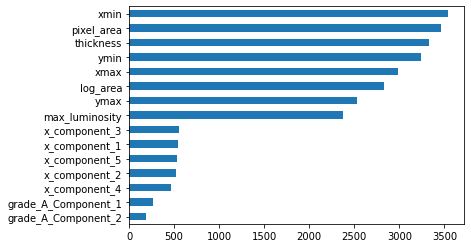

In [0]:
fi = pd.Series(index=features, data = clf.feature_importances_)
fi.sort_values(ascending=False)[:20][::-1].plot.barh()

In [0]:
predictions_test_lgb = clf.predict_proba(X_test)

In [0]:
submission = pd.DataFrame(data=predictions_test_lgb, columns=sub.columns)
submission.head()

,1,2
0,0.990275,0.009725
1,0.174104,0.825896
2,0.938625,0.061375
3,0.977104,0.022896
4,0.639293,0.360707


In [0]:
submission.to_excel('Output7.xlsx', index=False)

In [0]:
from google.colab import files
files.download('Output7.xlsx')